In [1]:
#####################################################
# Demand Forecasting
#####################################################

# Store Item Demand Forecasting Challenge
# https://www.kaggle.com/c/demand-forecasting-kernels-only
# !pip install lightgbm
# conda install lightgbm

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [2]:
########################
# Loading the data
########################

train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv')

df = pd.concat([train, test], sort=False)

In [3]:
#####################################################
# EDA
#####################################################

df["date"].min(), df["date"].max()

check_df(df)

df[["store"]].nunique()

df[["item"]].nunique()

df.groupby(["store"])["item"].nunique()

df.groupby(["store", "item"]).agg({"sales": ["sum"]})

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

df.head()

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [4]:
#####################################################
# FEATURE ENGINEERING
#####################################################


def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['week_of_year'] = df['week_of_year'].astype('int64')
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

df.head(10)

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
5,2013-01-06,1,1,12.0,NaN,1,6,6,1,6,2013,1,0,0
6,2013-01-07,1,1,10.0,NaN,1,7,7,2,0,2013,0,0,0
7,2013-01-08,1,1,9.0,NaN,1,8,8,2,1,2013,0,0,0
8,2013-01-09,1,1,12.0,NaN,1,9,9,2,2,2013,0,0,0
9,2013-01-10,1,1,9.0,NaN,1,10,10,2,3,2013,0,0,0


In [5]:
import pandas as pd

# Assuming df is your DataFrame
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [6]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [7]:
########################
# Lag/Shifted Features
########################

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

df.groupby(["store", "item"])['sales'].head()

df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year               int64
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

In [8]:
########################
# Rolling Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

In [9]:
########################
# Exponentially Weighted Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)


##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

In [10]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
########################
# One-Hot Encoding
########################

df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


#check_df(df)
df.head()
########################
# Converting sales to log(1+sales)
########################

df['sales'] = np.log1p(df["sales"].values)

#check_df(df)

In [12]:
#####################################################
# Model
#####################################################

In [13]:
########################
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [14]:
########################
# Time-Based Validation Sets
########################

train
test

# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [15]:
########################
# LightGBM ile Zaman Serisi Modeli
########################

# !pip install lightgbm
# conda install lightgbm


# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.356780 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.051391	training's SMAPE: 17.5991	valid_1's l2: 0.0532552	valid_1's SMAPE: 17.4899
[200]	training's l2: 0.0352274	training's SMAPE: 14.5646	valid_1's l2: 0.0370113	valid_1's SMAPE: 14.8784
[300]	training's l2: 0.0324348	training's SMAPE: 14.0128	valid_1's l2: 0.0340938	valid_1's SMAPE: 14.4178
[400]	training's l2: 0.031388	training's SMAPE: 13.7966	valid_1's l2: 0.0332622	valid_1's SMAPE: 14.2682
[500]	training's l2: 0.0307244	training's SMAPE: 13.6667	valid_1's l2: 0.0327063	valid_1's SMAPE: 14.1484
[600]	training's l2: 0.0302423	training's SMAPE: 13.5719	valid_1's l2: 0.0322472	valid_1's SMAPE: 14.0398
[700]	training's l2: 0.0298894	training's SMAPE: 13.5015	valid_1's l2: 0.0319363	valid_1's SMAPE: 13.966
[800]	training's l2: 0.0296106	tra

13.827628058376218

                        feature  split       gain
17          sales_roll_mean_546    928  54.230933
13                sales_lag_364   1253  13.135667
16          sales_roll_mean_365    624   9.906374
60   sales_ewm_alpha_05_lag_365    363   4.840321
18   sales_ewm_alpha_095_lag_91     96   2.704398
..                          ...    ...        ...
78                       item_6      0   0.000000
107                     item_35      0   0.000000
111                     item_39      0   0.000000
74                       item_2      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


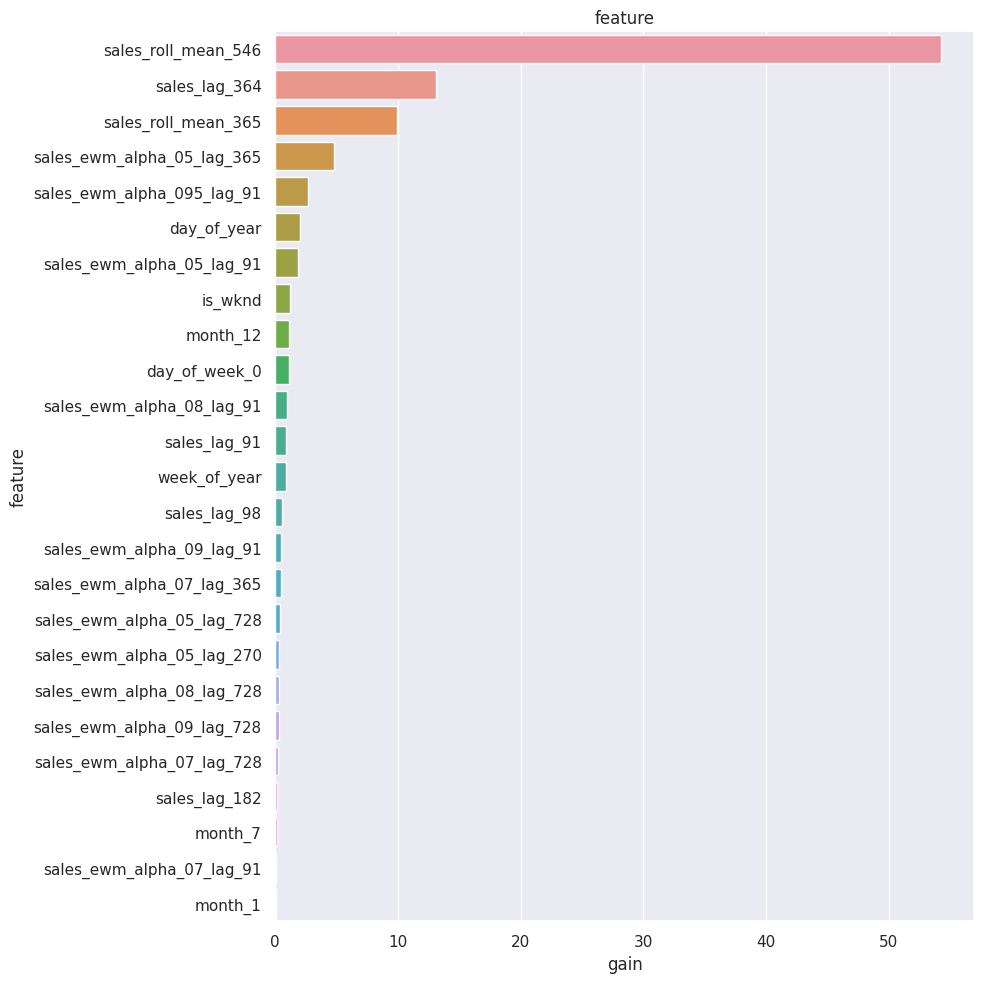

                        feature  split       gain
17          sales_roll_mean_546    928  54.230933
13                sales_lag_364   1253  13.135667
16          sales_roll_mean_365    624   9.906374
60   sales_ewm_alpha_05_lag_365    363   4.840321
18   sales_ewm_alpha_095_lag_91     96   2.704398
..                          ...    ...        ...
78                       item_6      0   0.000000
107                     item_35      0   0.000000
111                     item_39      0   0.000000
74                       item_2      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


110

In [16]:
########################
# Değişken Önem Düzeyleri
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

plot_lgb_importances(model, num=30, plot=True)


feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

In [17]:
########################
# Final Model
########################

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.443660 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [18]:
########################
# Submission File
########################

test.head()

submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission.csv", index=False)